# NBA player stats

## Scrape roster information for each NBA team

In [1]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd

Now, let’s create a function that will extract all the team names from http://www.espn.com/nba/teams and construct roster URLs for each of the teams:

In [2]:
# This method finds the urls for each of the rosters in the NBA using regexes.
def build_team_urls(URL):
    # Open the espn teams webpage and extract the names of each roster available.
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find("table", class_="Table--fixed-left")
    team_links = table.find_all("a", class_="AnchorLink")
    # Using the names of the rosters, create the urls of each roster
    roster_urls = []
    for link in team_links:
        elements = link.get("href").split("/")
        team_name = elements[-1]
        roster_urls.append((team_name, 'https://www.espn.com/nba/team/roster/_/name/' + elements[-2] + '/' + elements[-1]))
    return dict(roster_urls)

In [3]:
URL = 'https://www.espn.com/nba/stats/team/_/season/2021/seasontype/3'
rosters = build_team_urls(URL)
rosters

{'portland-trail-blazers': 'https://www.espn.com/nba/team/roster/_/name/por/portland-trail-blazers',
 'utah-jazz': 'https://www.espn.com/nba/team/roster/_/name/utah/utah-jazz',
 'philadelphia-76ers': 'https://www.espn.com/nba/team/roster/_/name/phi/philadelphia-76ers',
 'memphis-grizzlies': 'https://www.espn.com/nba/team/roster/_/name/mem/memphis-grizzlies',
 'denver-nuggets': 'https://www.espn.com/nba/team/roster/_/name/den/denver-nuggets',
 'brooklyn-nets': 'https://www.espn.com/nba/team/roster/_/name/bkn/brooklyn-nets',
 'boston-celtics': 'https://www.espn.com/nba/team/roster/_/name/bos/boston-celtics',
 'la-clippers': 'https://www.espn.com/nba/team/roster/_/name/lac/la-clippers',
 'milwaukee-bucks': 'https://www.espn.com/nba/team/roster/_/name/mil/milwaukee-bucks',
 'washington-wizards': 'https://www.espn.com/nba/team/roster/_/name/wsh/washington-wizards',
 'phoenix-suns': 'https://www.espn.com/nba/team/roster/_/name/phx/phoenix-suns',
 'atlanta-hawks': 'https://www.espn.com/nba/te

The function `build_team_urls()` returns a dictionary that matches team names with their corresponding roster URL. Given this information, we can systematically loop through all of the rosters and use regular expressions to extract player information for each team.

In [4]:
def get_player_info(roster_url):
    page = requests.get(roster_url)
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find("tbody")
    player_elements = table.find_all("td", class_="Table__TD")

    salary = []
    for element in player_elements[7::8]:
        salary.append(element.find("div").text.strip())

    play_info = dict()
    for idx, element in enumerate(player_elements[1::8]):
        link = element.find("a")
        player_id = re.findall(r'\d+', link.get("href"))[0]
        play_info[link.text.strip()] = {"id": player_id, "name": link.text.strip(), "salary": salary[idx]}

    return play_info

As you can see, `player_info` is a list of tuples, in which each player name is paired with a set of information (height, weight, age, etc.) that is organized in `json` format. We can use the `json` package in Python to convert the information into a Python dictionary:

We can now loop through each team in `rosters` and run `get_player_info()`, storing the output in a dictionary called `all_players`:

In [5]:
all_players = dict()
for team in rosters.keys():
    print("Gathering player info for team: " + team)
    all_players[team] = get_player_info(rosters[team])

Gathering player info for team: portland-trail-blazers
Gathering player info for team: utah-jazz
Gathering player info for team: philadelphia-76ers
Gathering player info for team: memphis-grizzlies
Gathering player info for team: denver-nuggets
Gathering player info for team: brooklyn-nets
Gathering player info for team: boston-celtics
Gathering player info for team: la-clippers
Gathering player info for team: milwaukee-bucks
Gathering player info for team: washington-wizards
Gathering player info for team: phoenix-suns
Gathering player info for team: atlanta-hawks
Gathering player info for team: dallas-mavericks
Gathering player info for team: miami-heat
Gathering player info for team: los-angeles-lakers
Gathering player info for team: new-york-knicks


After running this code, the `all_players` dictionary should be a dictionary of dictionaries of dictionaries. This sounds complicated, but let's walk through what it looks like. The first level of keys should correspond to teams:

In [6]:
all_players.keys()

dict_keys(['portland-trail-blazers', 'utah-jazz', 'philadelphia-76ers', 'memphis-grizzlies', 'denver-nuggets', 'brooklyn-nets', 'boston-celtics', 'la-clippers', 'milwaukee-bucks', 'washington-wizards', 'phoenix-suns', 'atlanta-hawks', 'dallas-mavericks', 'miami-heat', 'los-angeles-lakers', 'new-york-knicks'])

Within a team, the keys should correspond to player names. Let's zoom in on the LA Lakers:

In [7]:
all_players["los-angeles-lakers"].keys()

dict_keys(['Kostas Antetokounmpo', 'Devontae Cacok', 'Kentavious Caldwell-Pope', 'Alex Caruso', 'Anthony Davis', 'Andre Drummond', 'Jared Dudley', 'Marc Gasol', 'Montrezl Harrell', 'Talen Horton-Tucker', 'LeBron James', 'Kyle Kuzma', 'Wesley Matthews', 'Alfonzo McKinnie', 'Ben McLemore', 'Markieff Morris', 'Dennis Schroder'])

Now we can choose which player to look at. Let's choose LeBron James as an example:

In [8]:
all_players["los-angeles-lakers"]["Kostas Antetokounmpo"]

{'id': '4066490', 'name': 'Kostas Antetokounmpo', 'salary': '--'}

In order to make data analysis easier, we can re-format this dictionary into a `pandas` DataFrame. The function `pd.DataFrame.from_dict()` can turn a dictionary of dictionaries into a `pandas` DataFrame, as demonstrated below:

In the DataFrame above, each of the parameters such as 'age', 'salary', etc. are organized in columns and each player is a row. This makes display of the data much easier to read and understand. Furthermore, it also places null values when pieces of data are missing--for example, Chasson Randle's salary information is missing from the website, so 'NaN' is automatically placed in the DataFrame.

DataFrames allow us to quickly make calculations, sort players based on their stats, and compare stats between teams. To make a DataFrame containing data from all the teams, we will loop through each team in `all_players`, construct DataFrames, label them with a `team` column, and aggregate them into a single DataFrame called `all_players_df`.

In [9]:
all_players_df = pd.DataFrame()
# loop through each team, create a pandas DataFrame, and append
for team in all_players.keys():
    team_df = pd.DataFrame.from_dict(all_players[team], orient = "index")
    team_df['team'] = team
    all_players_df = all_players_df.append(team_df)

In [10]:
all_players_df.head(20)

,id,name,salary,team
Carmelo Anthony,1975,Carmelo Anthony,"$1,620,564",portland-trail-blazers
Keljin Blevins,3152335,Keljin Blevins,--,portland-trail-blazers
Zach Collins,4066650,Zach Collins,"$5,406,255",portland-trail-blazers
Robert Covington,2490620,Robert Covington,"$12,138,345",portland-trail-blazers
CJ Elleby,4397166,CJ Elleby,"$898,310",portland-trail-blazers
Harry Giles III,4065649,Harry Giles III,"$1,620,564",portland-trail-blazers
Rondae Hollis-Jefferson,3064291,Rondae Hollis-Jefferson,"$210,895",portland-trail-blazers
Derrick Jones Jr.,3936099,Derrick Jones Jr.,"$9,258,000",portland-trail-blazers
Enes Kanter,6447,Enes Kanter,"$5,005,350",portland-trail-blazers
T.J. Leaf,4066425,T.J. Leaf,"$4,326,825",portland-trail-blazers


Now, `all_players_df` is a DataFrame with all the players in the NBA categorized by team. It contains player information such as age, salary, height, weight, etc. I'll export this data to a csv file, in case you readers out there want to read it in and play around with it yourself.

## Scrape player stats for career averages

We also want to scrape data coresponding to the performance of each player, in terms of points per game, field goal percentage, rebounds per game, etc. Our goal is to append this information to `all_players_df` so that we can compare player performance with traits such as height, salary, etc. We can find performance stats at each player's personal page on ESPN:

In order to extract the information above for each player in our DataFrame, we can construct URLs for player stats pages using the `id` column. Fortunately, the URL is standardized and very easy to construct. For example, using the `id` value of 3975 for Stephen Curry, the URL to open would be: https://www.espn.com/nba/player/stats/_/id/3975. Below is an example of extracting his career stats using regexes:

In [11]:
url = "https://www.espn.com/nba/player/stats/_/id/1975/type/nba/seasontype/3"

def get_player_stats(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find_all("tbody")[1].find_all("tr")[-1]
    stats = [element.find("span").text.strip() for element in table]
    return list(map(float, [stats[2], stats[11], stats[12], stats[-1]]))


We observe that some of the stats are complex and contain non-numerical symbols such as "-". In the example above, the range "3.7-4.0" is for the column "FT", which stands for "Free Throws Made-Attempted Per Game". We should split this up into two categories, "Free Throws Made (FTM)" and "Free Throws Attempted (FTA)", and do the same for field goals and 3 pointers. To do so, we can split the string based on "-" and then un-nest the list. We also need to convert the strings to floating point values.

Now we can loop through each player in `all_players_df`, open their stats webpage, extract their career stats, and store the stats in a separate data frame called `career_stats_df` using the code below:

In [12]:
career_stats_df = pd.DataFrame(columns = ["MIN", "REB", "AST", "PTS"])
for idx, row in all_players_df.iterrows():
    url = "https://www.espn.com/nba/player/stats/_/id/" + str(row['id']) + "/type/nba/seasontype/3"
    try:
        career_info = get_player_stats(url)
        career_stats_df = career_stats_df.append(pd.Series(career_info, index = career_stats_df.columns, name=idx))
    except:
        # if no career stats were returned, the player was a rookie with no games played
        print(idx + " has no info, " + url)

Elijah Hughes has no info, https://www.espn.com/nba/player/stats/_/id/4066446/type/nba/seasontype/3
Sean McDermott has no info, https://www.espn.com/nba/player/stats/_/id/3908903/type/nba/seasontype/3
Jontay Porter has no info, https://www.espn.com/nba/player/stats/_/id/4278103/type/nba/seasontype/3
Killian Tillie has no info, https://www.espn.com/nba/player/stats/_/id/4066651/type/nba/seasontype/3
Moses Brown has no info, https://www.espn.com/nba/player/stats/_/id/4397126/type/nba/seasontype/3
Deni Avdija has no info, https://www.espn.com/nba/player/stats/_/id/4683021/type/nba/seasontype/3
Thomas Bryant has no info, https://www.espn.com/nba/player/stats/_/id/3934723/type/nba/seasontype/3
Caleb Homesley has no info, https://www.espn.com/nba/player/stats/_/id/3947736/type/nba/seasontype/3
Brandon Goodwin has no info, https://www.espn.com/nba/player/stats/_/id/3057198/type/nba/seasontype/3
Tyler Bey has no info, https://www.espn.com/nba/player/stats/_/id/4278502/type/nba/seasontype/3
Nat

Some player webpages did not have career stats, which I found corresponded to rookies which had no games played. This threw an error in the loop, so I used a try/except clause to bypass the error and continue stripping content for the remaining players. Their stats are currently stored in the object `career_stats_df`:

In [13]:
career_stats_df.head(5)

,MIN,REB,AST,PTS
Carmelo Anthony,37.3,6.7,2.5,23.1
Keljin Blevins,2.0,0.0,0.0,1.0
Zach Collins,17.3,3.5,1.0,6.9
Robert Covington,31.7,5.7,1.7,9.7
CJ Elleby,4.0,1.5,0.5,0.0


The stats for each player are now organized in a neat DataFrame. Here is a legend for what each of the abbreviations mean:

* MIN:Minutes Per Game
* REB:Rebounds Per Game
* AST:Assists Per Game
* PTS:Points Per Game

## Joining and cleaning the data

We will now join `career_stats_df` with `all_players_df`, which will merge the content from both data frames based on rows that have the same index (player name). Players in `all_players_df` that are not included in `career_stats_df` will have `NaN` values for the joined columns.

In [14]:
all_stats_df = all_players_df.join(career_stats_df)

In [15]:
all_stats_df.head(5)

,id,name,salary,team,MIN,REB,AST,PTS
Carmelo Anthony,1975,Carmelo Anthony,"$1,620,564",portland-trail-blazers,37.3,6.7,2.5,23.1
Keljin Blevins,3152335,Keljin Blevins,--,portland-trail-blazers,2.0,0.0,0.0,1.0
Zach Collins,4066650,Zach Collins,"$5,406,255",portland-trail-blazers,17.3,3.5,1.0,6.9
Robert Covington,2490620,Robert Covington,"$12,138,345",portland-trail-blazers,31.7,5.7,1.7,9.7
CJ Elleby,4397166,CJ Elleby,"$898,310",portland-trail-blazers,4.0,1.5,0.5,0.0


The performance stats have been added as columns on the right side of the DataFrame.

We notice that some of the columns which should contain numerical data such as salary, height, and weight are instead considered strings. This is beacuse they contain non-numerical characters (such as '$' and ',' for salary). To be able to compute statistics on these columns, we need to convert them to numeric values.

We can convert salaries to numeric by removing all non-numerical characters and converting to `int` using list comprehension:

In [16]:
all_stats_df['salary'] = all_stats_df['salary'].replace("--", pd.NA)


In [17]:
all_stats_df['salary']=[float(re.sub(r'[^\d.]+', '', s)) if isinstance(s, str) else s for s in all_stats_df['salary'].values]

In [18]:
# all_stats_df.to_json("NBA_player_info.json", orient="records")

## Calculating statistics

In [19]:
all_stats_df.sort_values('salary', ascending=False).head(10)

,id,name,salary,team,MIN,REB,AST,PTS
Russell Westbrook,3468,Russell Westbrook,41358814.0,washington-wizards,37.5,7.2,7.9,24.6
Chris Paul,2779,Chris Paul,41358814.0,phoenix-suns,36.8,5.0,8.3,20.7
James Harden,3992,James Harden,41254920.0,brooklyn-nets,35.4,5.5,6.0,23.3
Kevin Durant,3202,Kevin Durant,40108950.0,brooklyn-nets,40.3,7.8,4.0,29.5
LeBron James,1966,LeBron James,39219565.0,los-angeles-lakers,41.5,9.0,7.2,28.7
Paul George,4251,Paul George,35450412.0,la-clippers,39.1,7.5,4.1,21.3
Mike Conley,3195,Mike Conley,34502130.0,utah-jazz,36.3,3.6,6.7,16.7
Kawhi Leonard,6450,Kawhi Leonard,34379100.0,la-clippers,35.5,7.9,2.8,21.2
Jimmy Butler,6430,Jimmy Butler,34379100.0,miami-heat,37.6,5.8,4.3,18.5
Tobias Harris,6440,Tobias Harris,34358850.0,philadelphia-76ers,37.1,9.0,3.7,17.8


In [20]:
cleaned_df = all_stats_df.loc[~all_stats_df["salary"].isnull(), :]

In [21]:
cleaned_df["salary"] = cleaned_df["salary"].astype(int)

e:\Onedrive\Documents\Kaggle\NBA\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
# calculate means and remove irrelevant columns for id #
mean_df = cleaned_df.groupby('team').mean()

In [23]:
mean_df.sort_values('salary', ascending=False).head(5)

,salary,MIN,REB,AST,PTS
team,,,,,
brooklyn-nets,1.075938e+07,23.213333,4.086667,1.980000,11.213333
la-clippers,9.084385e+06,22.760000,4.200000,2.033333,9.573333
utah-jazz,9.010809e+06,21.242857,3.871429,1.735714,9.000000
los-angeles-lakers,8.759466e+06,23.826667,4.440000,1.846667,11.093333
philadelphia-76ers,8.695312e+06,19.629412,3.852941,1.541176,8.370588


Looks like the highest average salary is paid by the brooklyn-nets. Similarly, we can find the top 10 highest paid players by sorting `all_stats_df` on salary:

In [24]:
cleaned_df.sort_values('salary', ascending=False)[['salary','team']].head(10)

,salary,team
Russell Westbrook,41358814,washington-wizards
Chris Paul,41358814,phoenix-suns
James Harden,41254920,brooklyn-nets
Kevin Durant,40108950,brooklyn-nets
LeBron James,39219565,los-angeles-lakers
Paul George,35450412,la-clippers
Mike Conley,34502130,utah-jazz
Kawhi Leonard,34379100,la-clippers
Jimmy Butler,34379100,miami-heat
Tobias Harris,34358850,philadelphia-76ers


Create a metric with the stats available here.
(PTS + 0.01) * (MIN + 0.01) * (REB + 0.01) * (AST + 0.01)

In [25]:
all_stats_df["metric"] = (all_stats_df["PTS"] + 0.01 ) * (all_stats_df["MIN"] + 0.01) * (all_stats_df["REB"] + 0.01) * (all_stats_df["AST"] + 0.01)

In [26]:
", ".join(list(all_stats_df.sort_values('metric', ascending=False)[['metric','team']].head(10).index))

'Luka Doncic, LeBron James, Nikola Jokic, Giannis Antetokounmpo, Russell Westbrook, Ja Morant, Kevin Durant, Chris Paul, Julius Randle, Ben Simmons'

In [27]:
def top_n(df, category, n):
    return (df.sort_values(category, ascending=False)[[category,'team']].head(n))

This way, we can quickly identify the top n players for any given category in a DataFrame. Let's cycle through some stats of interest:

In [28]:
top_n(cleaned_df, 'PTS', 5)

,PTS,team
Luka Doncic,33.5,dallas-mavericks
Ja Morant,30.2,memphis-grizzlies
Kevin Durant,29.5,brooklyn-nets
Trae Young,28.8,atlanta-hawks
Donovan Mitchell,28.8,utah-jazz


In [29]:
top_n(cleaned_df, 'REB', 5)

,REB,team
Dwight Howard,11.8,philadelphia-76ers
Deandre Ayton,11.8,phoenix-suns
Julius Randle,11.6,new-york-knicks
Giannis Antetokounmpo,11.6,milwaukee-bucks
Nikola Jokic,11.3,denver-nuggets


In [30]:
corr_matrix = cleaned_df.drop(['id'],1).corr()

e:\Onedrive\Documents\Kaggle\NBA\venv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


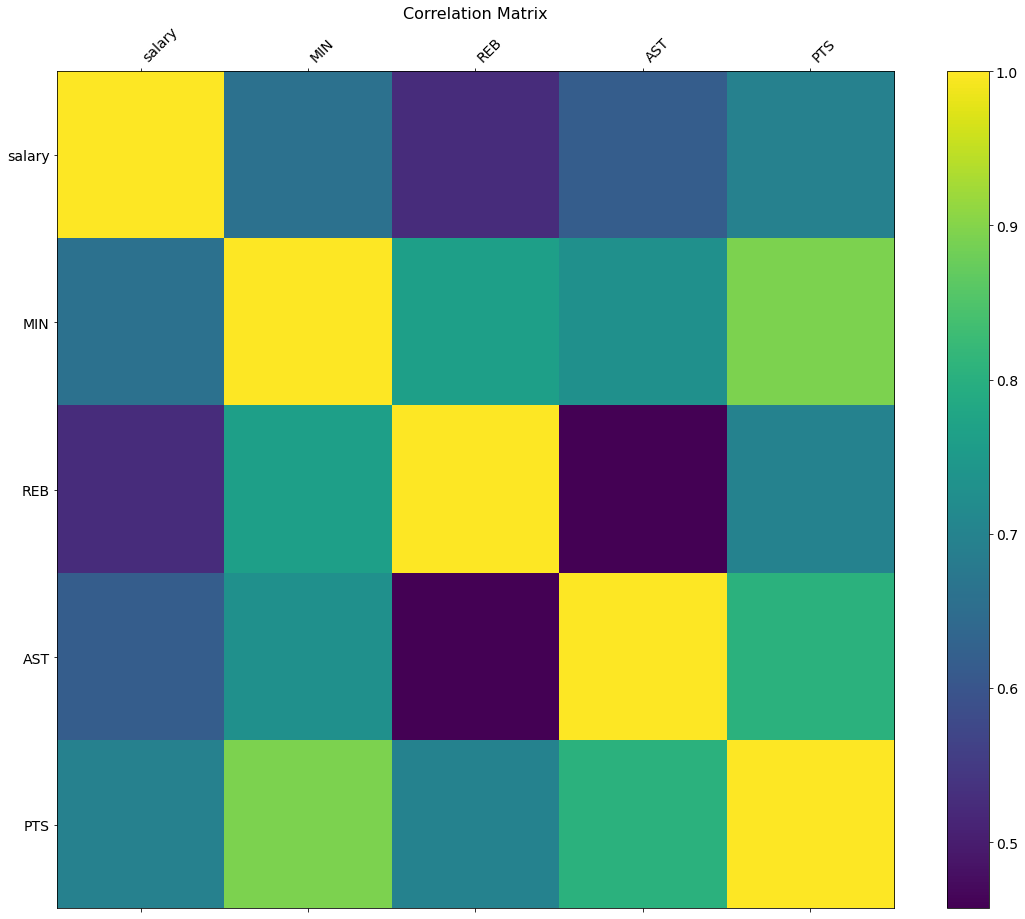

In [31]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14, rotation=45, ha = 'left')
plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

We can learn a lot about how different statistics are associated with each other from this matrix, and also identify some interesting trends. For example:

* Points per game (PTS) is highly correlated with minitues played in game (MIN).
* The highest correlates with salary is points per game, which is one of the more important stats when it comes down to performance.

In [32]:
corr_matrix.sort_values('salary', ascending=False)['salary'].head(10)

salary    1.000000
PTS       0.696451
MIN       0.658777
AST       0.617753
REB       0.526738
Name: salary, dtype: float64

In [33]:
from sklearn.linear_model import LinearRegression
# remove rows with null values for regression
reg_df = all_stats_df[['salary', 'PTS']].dropna()

Then, we will fit the model with the predictor variable (X) being PTS and the dependent variable (Y) being salary. We will set `fit_intercept=False` since players cannot be paid less than $0.00 or score less than 0 PTS:

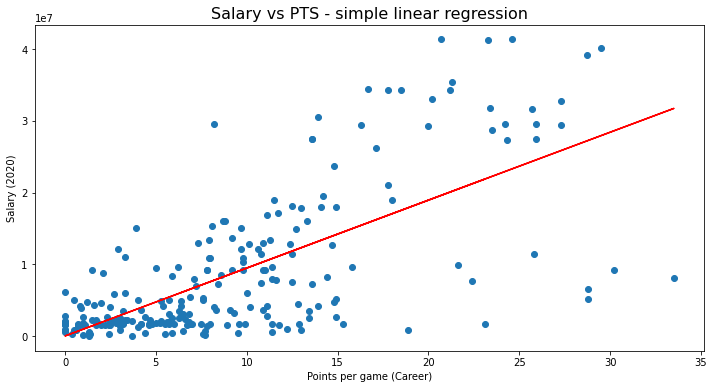

In [34]:
X = reg_df['PTS'].values.reshape(-1,1)
Y = reg_df['salary'].values.reshape(-1,1)
reg = LinearRegression(fit_intercept=False).fit(X,Y)
y_pred = reg.predict(X)
plt.figure(figsize=(12, 6))
plt.scatter(X, Y)
plt.plot(X, y_pred, color='red')
plt.xlabel("Points per game (Career)")
plt.ylabel("Salary (2020)")
plt.title('Salary vs PTS - simple linear regression', fontsize=16);

Consistent with the positive correlation we calculated previously, a regression line with a positive slope is fitted to the data. We can extract the slope of the line by getting the coefficient using `.coef_`:

In [35]:
print(reg.coef_)

[[947335.99054586]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [45]:
all_stats_df = all_stats_df.dropna(subset=["MIN", "PTS", "REB", "AST"])

In [46]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer().fit(all_stats_df.loc[:, ["MIN", "PTS", "REB", "AST"]])
normalizer.transform(all_stats_df.loc[:, ["MIN", "PTS", "REB", "AST"]])

array([[0.83909468, 0.51965381, 0.1507221 , 0.05623959],
       [0.89442719, 0.4472136 , 0.        , 0.        ],
       [0.91160016, 0.36358619, 0.18442778, 0.05269365],
       ...,
       [0.85555351, 0.42777675, 0.27567835, 0.0950615 ],
       [0.85062197, 0.49619615, 0.0974671 , 0.14398549],
       [0.88274161, 0.43458049, 0.17654832, 0.02716128]])

In [47]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer().fit(all_stats_df.loc[:, ["MIN", "PTS", "REB", "AST"]])
normalizer.transform(all_stats_df.loc[:, ["MIN", "PTS", "REB", "AST"]])

array([[0.83909468, 0.51965381, 0.1507221 , 0.05623959],
       [0.89442719, 0.4472136 , 0.        , 0.        ],
       [0.91160016, 0.36358619, 0.18442778, 0.05269365],
       ...,
       [0.85555351, 0.42777675, 0.27567835, 0.0950615 ],
       [0.85062197, 0.49619615, 0.0974671 , 0.14398549],
       [0.88274161, 0.43458049, 0.17654832, 0.02716128]])

In [58]:
columns = ["MIN", "PTS", "REB", "AST"]
# normalize
normalized_df = Normalizer().fit_transform(all_stats_df.loc[:, columns])
normalized_df = pd.DataFrame(normalized_df, columns=columns)
normalized_df

,MIN,PTS,REB,AST
0,0.839095,0.519654,0.150722,0.056240
1,0.894427,0.447214,0.000000,0.000000
2,0.911600,0.363586,0.184428,0.052694
3,0.941204,0.288003,0.169239,0.050475
4,0.929981,0.000000,0.348743,0.116248
...,...,...,...,...
248,0.910440,0.374153,0.124718,0.124718
249,0.930756,0.350544,0.084614,0.060439
250,0.855554,0.427777,0.275678,0.095062
251,0.850622,0.496196,0.097467,0.143985


In [66]:
scale = (normalized_df.max() - normalized_df.min())/100
metric = 100 * ((normalized_df["PTS"] + scale["PTS"] ) * (normalized_df["MIN"] + scale["MIN"]) * (normalized_df["REB"] + scale["REB"]) * (normalized_df["AST"] + scale["AST"]))

In [85]:
all_stats_df["metric"] = metric.values * 100
all_stats_df.loc[:, "metric"]

Carmelo Anthony       41.974824
Keljin Blevins         0.097014
Zach Collins          36.662554
Robert Covington      26.674665
CJ Elleby              3.560489
                        ...    
Theo Pinson           59.221695
Immanuel Quickley     19.682554
Julius Randle        104.631097
Derrick Rose          66.607128
Obi Toppin            22.066242
Name: metric, Length: 253, dtype: float64

In [80]:
pd.Series(metric.values, index=all_stats_df.index, name="metric")

Carmelo Anthony      0.419748
Keljin Blevins       0.000970
Zach Collins         0.366626
Robert Covington     0.266747
CJ Elleby            0.035605
                       ...   
Theo Pinson          0.592217
Immanuel Quickley    0.196826
Julius Randle        1.046311
Derrick Rose         0.666071
Obi Toppin           0.220662
Name: metric, Length: 253, dtype: float64

In [79]:
metric*100

0       41.974824
1        0.097014
2       36.662554
3       26.674665
4        3.560489
          ...    
248     59.221695
249     19.682554
250    104.631097
251     66.607128
252     22.066242
Name: metric, Length: 253, dtype: float64